# <img src="./assets/course-icon.png" style="height:50px;display:inline"> EE 046211 - Technion - Deep Learning
---

#### Tal Daniel

## Tutorial 05 - Multilayer Neural Networks
---
<img src="./assets/mlp.jpg" style="height:200px">

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* [Multi-Layer Perceptron (MLP)](#-Multi-Layer-Perceptron-(MLP))
* [Modular Approach - Autodiff Reverse Mode](#-Modular-Approach---Autodiff-Reverse-Mode)
* [Example - Neural Networks for Regression - Housing Prices](#-Example---Neural-Networks-for-Regression---Housing-Prices)
* [Building a Neural Network with PyTorch](#-Building-a-Neural-Network-with-PyTorch)
* [Weights Initialization](#-Weights-Initialization)
* [Neural Network Weight Initialization with PyTorch](#-Neural-Network-Weight-Initialization-with-PyTorch)
* [Deep Double Descent](#-Deep-Double-Descent)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

#### <img src="./assets/colab_icon.PNG" style="height:30px;display:inline"> Additional Packeges for Google Colab
----
If you are using <a href="https://colab.research.google.com/">Google Colab</a>, you have to install additional packages. To do this, simply run the following cell.

In [ ]:
# to work locally (win/linux/mac), first install 'graphviz': https://graphviz.org/download/ and restart your machine
!pip install torchviz

In [1]:
# imports for the tutorial
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchviz
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

### <img src="https://img.icons8.com/dusk/64/000000/layers.png" style="height:50px;display:inline"> Multi-Layer Perceptron (MLP)
---
* An MLP is composed of one input layer, one or more hidden layers and a final output layer. 
* Every layer, except the output layer includes a **bias neuron** which is fully connected to the next layer. 
* When the number of hidden layers is larger than 2, the network is usually called a deep neural network (DNN).

* The algorithm is composed of two main parts: **forward pass and backward pass**.
* In the *forward pass*, for each training instance, the algorithm feeds it to the network and computes the output of every neuron in each consecutive layer (using the network for prediction is just doing a forward pass). 
* Then, the output error (the difference between the desired output and the actual output from the network) is computed.

* After the output error calculation, the network calculates how much each neuron in the last hidden layer contributed to the output error (using the **chain rule**).
* It then proceeds to measure how much of these error contributions came from each neuron in the previous layers until reaching the input layer. 
* This is the *backward pass*: measuring the error gradient across all the connection weights in the network by propagating the error gradient backward in the network (this is the backpropagation process).

In short: for each training instance the **backpropagation algorithm** first makes a prediction (forward pass), measures the error, then goes in reverse to measure the error contribution from each connection (backward pass) and finally, using Gradient Descent, updates the weights in the direction that reduces the error.

<img src="./assets/mlp_example.jpg" style="height:300px">

For example, if: $$ X \in \mathbb{R}^2 $$ $$ W_1 \in \mathbb{R}^{2 \times 4} $$ $$ W_2 \in \mathbb{R}^{4 \times 3} $$ $$ W_3 \in \mathbb{R}^{3 \times 1} $$ $$ b_1 \in \mathbb{R}^4 $$ $$ b_2 \in \mathbb{R}^3 $$ $$ b_3 \in \mathbb{R} $$ Then: $$ F(X,W) = W_3^T \phi_2(W_2^T\phi_1(W_1^TX + b_1) + b_2) + b_3 $$

The key change made to the Perceptron that brought upon the era of deep learning is the addition of **activation function** to the output of each neuron. These allow the learning of non-linear functions. We will use three popular activation functions:
1. **Logistic function (sigmoid)**: $\sigma(z) = \frac{1}{1 + e^{-z}}$. The output is in $[0,1]$ which can be used for binary clssification or as a probability (why?)
2. **Hyperbolic tangent function**: $tanh(z) = 2\sigma(2z) - 1$. The output is in $[-1,1]$ which tends to make each layer's output more or less normalized at the beginning of the training (which may speed up convergence).
3. **ReLU (Rectified Linear Unit) function**: $ReLU(z) = max(0,z)$. Continuous but not differentiable at $z=0$. However, it is the most common activation function as it is fast to compute and does not bound the output (which helps with some issues during Gradient Descent).

## <img src="https://img.icons8.com/dusk/64/000000/lego-head.png" style="height:50px;display:inline"> Modular Approach - Autodiff Reverse Mode
---
* We code **layers**, not networks.
* Layer Specification - each layer needs to provide 3 functions:
    1. The layer output given its input (forward pass)
    2. Derivative with respect to the input
    3. Derivative with respect to parameters

Illustration: <img src="./assets/modular_approach_1.jpg" style="height:350px">

Zoom-in: <img src="./assets/modular_approach_2.jpg" style="height:200px">

### <img src="https://img.icons8.com/plasticine/100/000000/serial-tasks.png" style="height:50px;display:inline"> Backpropagation
---
We now establish a common language when it comes to neural networks architecture:
* **Forward Pass**: $Z^{(k+1)} = f(Z^{(k)}) $
* **Backward Pass**: $\delta^{(k+1)} = \frac{\partial E}{\partial Z^{(k+1)}}$
* Applying the **chain rule** for a single layer: $$ \frac{\partial E}{\partial Z^{(k)}} = \frac{\partial E}{\partial Z^{(k+1)}} \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = \delta^{(k+1)}\frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = \delta^{(k+1)}\frac{\partial f(Z^{(k)})}{\partial Z^{(k)}} $$
* The **gradient with respect to layer parameters** (if it has any): $$ \frac{\partial E}{\partial W^{(k)}} = \frac{\partial E}{\partial Z^{(k+1)}} \frac{\partial Z^{(k+1)}}{\partial W^{(k)}} = \delta^{(k+1)} \frac{\partial Z^{(k+1)}}{\partial W^{(k)}}  $$

### <img src="https://img.icons8.com/color/96/000000/3d-glasses.png" style="height:50px;display:inline"> Extension to Multi-Dimensions
---
* $f: \mathbb{R}^n \to \mathbb{R}^m$ is a vector function of a vector variable: $$ f(x) = \begin{bmatrix} f_1(x) \\ \vdots \\ f_m(x) \end{bmatrix}, x \in \mathbb{R}^n, f(x) \in \mathbb{R}^m $$
* The **gradient** is given by: $$ \frac{\partial f_i}{\partial x} = \big[ \frac{\partial f_i(x)}{\partial x_1}, ..., \frac{\partial f_i(x)}{\partial x_n} \big] $$
* The **Jacobian**, $J_f(x) \in \mathbb{R}^{m \times n}$, is given by: $$ J_f(x) = \begin{bmatrix} \frac{\partial f_1(x)}{\partial x}\\ \vdots\\ \frac{\partial f_m(x)}{\partial x} \end{bmatrix} = \begin{bmatrix} \frac{\partial f_1}{\partial x_1} && \cdots && \frac{\partial f_1}{\partial x_n} \\ \vdots && \ddots && \vdots \\ \frac{\partial f_m}{\partial x_1} && \cdots && \frac{\partial f_m}{\partial x_n} \end{bmatrix} $$

* **The Chain Rule**:
    * Given: $$ F: \mathbb{R}^n \to \mathbb{R}^m $$ $$ \phi: \mathbb{R}^m \to \mathbb{R}^k $$ $$ \psi(x)= \phi(F(x)) $$
    * The Jacobian is given by: $$ J_{\psi} = J_{\phi} J_F $$ $$ J_{\phi} \in \mathbb{R}^{k \times m}, J_F \in  \mathbb{R}^{m \times n} \to J_{\psi} \in \mathbb{R}^{k \times n}$$

<img src="./assets/backprop_anim.gif" style="height:350px">

<a href="https://anatomiesofintelligence.github.io/posts/2018-10-16-forward-back-propogation">Image Source</a>

### <img src="https://img.icons8.com/dusk/64/000000/popular-topic.png" style="height:50px;display:inline"> Commonly Used Layers (as Modular Blocks)
---
* Linear Layer (linear combination of the inputs)
* Activation Layer (usually together with the linear layer, apply a function on the linear combination of weighted inputs): ReLU, Binary Step, Sigmoid, TanH...
* Softmax Layer (Sigmoid for for than 2 classes, outputs the probability of each class)
* Loss Function Layer (MSE, Cross Entropy...)

## <img src="https://img.icons8.com/dusk/64/000000/home.png" style="height:50px;display:inline"> Example - Neural Networks for Regression - Housing Prices
---
* The Housing Prices Dataset:
    * Two input features: *Size* and *Floor*
    * One output: *House Price*
    * **Loss function**: MSE
* Suggested **network architecture**: 2 hidden layers
    * Two inputs, one for each feature
    * Four neurons in the *first hidden layer*
    * Three neurons in the *second hidden layer*
    * One output

Layout: <img src="./assets/mlp_example.jpg" style="height:300px"> $$ F(X,W) = W_3^T \phi_2(W_2^T\phi_1(W_1^TX + b_1) + b_2) + b_3 $$

Where: $$ X \in \mathbb{R}^2 $$ $$ W_1 \in \mathbb{R}^{2 \times 4} $$ $$ W_2 \in \mathbb{R}^{4 \times 3} $$ $$ W_3 \in \mathbb{R}^{3 \times 1} $$ $$ b_1 \in \mathbb{R}^4 $$ $$ b_2 \in \mathbb{R}^3 $$ $$ b_3 \in \mathbb{R} $$

### <img src="https://img.icons8.com/office/80/000000/baby-footprints-path.png" style="height:50px;display:inline"> Step-by-Step Solution
---
* The MSE loss function over all the training examples $x_i$ and the corresponding training targets: $$ Error = \frac{1}{N} \sum_{i=1}^N (F(x_i, W) - y_i)^2 = \frac{1}{N} ||F(X, W) - Y||_2^2 $$
* Linear Layer: $$ u_{out} = W^Tu_{in} + b $$

* Activation Layer:
    * $\phi_1$ and $\phi_2$ are multivariate vector *nonlinear* functions, such that: $$ \phi(U) = \phi\left(\begin{bmatrix} u_1 \\ \vdots \\ u_n \end{bmatrix}\right) = \begin{bmatrix} \phi(u_1) \\ \vdots \\ \phi(u_n) \end{bmatrix} $$
    * For **ReLU**: $$ \begin{bmatrix} \phi(u_1) \\ \vdots \\ \phi(u_n) \end{bmatrix} = \begin{bmatrix} \max(0, u_1) \\ \vdots \\ \max(0, u_n) \end{bmatrix} $$ 

#### <img src="https://img.icons8.com/color/96/000000/layers.png" style="height:20px;display:inline"> The Linear Layer
---
* **Forward Pass**: $$Z^{(k+1)} = f(Z^{(k)}) = (W^{(k)})^T Z^{(k)} + b^{(k)}$$
    * $k$ denotes the $k^{th}$ layer with the corresponding weights and bias $W^{(k)}, b^{(k)}$
* **Derivative** with respect to *input* $Z^{(k)}$: $$ \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = \frac{\partial ((W^{(k)})^T Z^{(k)} + b^{(k)})}{\partial Z^{(k)}} = (W^{(k)})^T $$ <br> $$ \delta^{(k)} = \delta^{(k+1)} (W^{(k)})^T  $$
* **Derivative** with respect to the *parameters* $W^{(k)}, b^{(k)}$: $$ \frac{\partial Z^{(k+1)}}{\partial W^{(k)}} = Z^{(k)} ,\frac{\partial E}{\partial W^{(k)}} = \delta^{(k+1)} Z^{(k)} $$ <br> $$  \frac{\partial Z^{(k+1)}}{\partial b^{(k)}} = I,  \frac{\partial E}{\partial b^{(k)}} = \delta^{(k+1)}$$

####  <img src="https://img.icons8.com/color/96/000000/layers.png" style="height:20px;display:inline">  The ReLU Layer
---
* **Forward Pass**: $$ Z^{(k+1)} = \begin{bmatrix} max(0,Z_1^{(k)}) \\ \vdots \\ max(0,Z_n^{(k)}) \end{bmatrix}, ReLU(Z): \mathbb{R}^{n} \to \mathbb{R}^n $$
* **Derivative** with respect to *input* $Z^{(k)}$: $$ \phi = max(0,Z^{(k)}), \phi' = heaviside(Z^{(k)}) $$ <br> $$ \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = diag(\phi') $$ <br> $$ \delta^{(k)} = \delta^{(k+1)} diag (\phi') $$
* **Derivative** with respect to the *parameters*: **NO PARAMETERS!**

####  <img src="https://img.icons8.com/color/96/000000/layers.png" style="height:20px;display:inline">  The MSE Layer 
---
* **Forward Pass**: $$ E = Z^{(k+1)} = (Z^{(k)} - y)^2 $$
*  **Derivative** with respect to *input* $Z^{(k)}$: $$ \delta^{(k+1)} = \frac{\partial E}{\partial Z^{(k+1)}} = \frac{\partial E}{\partial E} = 1 $$ <br> $$ \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = 2(Z^{(k)} - y) $$ <br> $$ \delta^{(k)} = \delta^{(k+1)} 2(Z^{(k)} - y) =  2(Z^{(k)} - y) $$

### <img src="https://img.icons8.com/dusk/64/000000/fast-forward.png" style="height:50px;display:inline"> Forward Pass
---
$$ F(X,W) = W_3^T \phi_2(W_2^T\phi_1(W_1^TX + b_1) + b_2) + b_3 $$
<img src="./assets/forward_pass.JPG" style="height:300px">

### <img src="https://img.icons8.com/dusk/64/000000/rewind.png" style="height:50px;display:inline"> Backward Pass
---
<img src="./assets/backward_pass.JPG" style="height:400px">

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Building a Neural Network with PyTorch
---
We will now implement a neural network for regression with PyTorch. We will use the "Boston House Prices" dataset and use the architecture described above.

In [2]:
# define our neural network model
class HousePricesMLP(nn.Module):
    # notice that we inherit from nn.Module
    def __init__(self, input_dim, output_dim):
        super(HousePricesMLP, self).__init__()
        # here we initialize the building blocks of our network
        # single neuron is just one linear (fully-connected) layer
        self.fc_1 = nn.Linear(input_dim, 4) 
        self.fc_2 = nn.Linear(4, 3)
        self.output_layer = nn.Linear(3, output_dim)

    def forward(self, x):
        # here we define what happens to the input x in the forward pass
        # that is, the order in which x goes through the building blocks
        # in our case, x first goes through the signle neuron and then activated with sigmoid
        x = torch.relu(self.fc_1(x))
        x = torch.relu(self.fc_2(x))
        return self.output_layer(x)

In [3]:
# alternative method
class HousePricesMLP(nn.Module):
    # notice that we inherit from nn.Module
    def __init__(self, input_dim, output_dim):
        super(HousePricesMLP, self).__init__()
        # here we initialize the building blocks of our network
        # single neuron is just one linear (fully-connected) layer
        self.hidden = nn.Sequential(nn.Linear(input_dim, 4),
                                    nn.ReLU(),
                                    nn.Linear(4, 3),
                                    nn.ReLU())
        self.output_layer = nn.Linear(3, output_dim)

    def forward(self, x):
        # here we define what happens to the input x in the forward pass
        # that is, the order in which x goes through the building blocks
        # in our case, x first goes through the signle neuron and then activated with sigmoid
        return self.output_layer(self.hidden(x))

In [4]:
# load data and preprocess
boston_dataset = load_boston()
# print description of the features
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
# the target is the MEDV field - median value of owner-occupied homes in 1000$
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.sample(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
10,0.22489,12.5,7.87,0.0,0.524,6.377,94.3,6.3467,5.0,311.0,15.2,392.52,20.45,15.0
220,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7
422,12.04820,0.0,18.10,0.0,0.614,5.648,87.6,1.9512,24.0,666.0,20.2,291.55,14.10,20.8
296,0.05372,0.0,13.92,0.0,0.437,6.549,51.0,5.9604,4.0,289.0,16.0,392.85,7.39,27.1
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
351,0.07950,60.0,1.69,0.0,0.411,6.579,35.9,10.7103,4.0,411.0,18.3,370.78,5.49,24.1
261,0.53412,20.0,3.97,0.0,0.647,7.520,89.4,2.1398,5.0,264.0,13.0,388.37,7.26,43.1
347,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36,23.1
175,0.06664,0.0,4.05,0.0,0.510,6.546,33.1,3.1323,5.0,296.0,16.6,390.96,5.33,29.4
416,10.83420,0.0,18.10,0.0,0.679,6.782,90.8,1.8195,24.0,666.0,20.2,21.57,25.79,7.5


In [6]:
# we will use 2 features
x = boston[['RM', 'LSTAT']].values  # RM-num rooms, LSTAT-% lower status of the population
y = boston['MEDV'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=5)
# scaling
x_scaler = StandardScaler()
x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)
print("total training samples: {}, total test samples: {}".format(len(x_train),len(x_test)))

total training samples: 404, total test samples: 102


In [7]:
# convert to tensor dataset for PyTorch
boston_tensor_train_ds = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
# check
print(f'sample 0: features: {boston_tensor_train_ds[0][0]}, target: {boston_tensor_train_ds[0][1]}')

sample 0: features: tensor([-0.8488,  0.8353]), target: 13.100000381469727


In [8]:
# define hyper-parmeters and create our model
num_features = 2
output_dim = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 500
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# loss criterion
criterion = nn.MSELoss()
# model
model = HousePricesMLP(num_features, output_dim).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
boston_tensor_train_dataloader = DataLoader(boston_tensor_train_ds, batch_size=batch_size)

# training loop for the model
for epoch in range(num_epochs):
    epoch_losses = []
    for features, targets in boston_tensor_train_dataloader:
        # send data to device
        features = features.to(device)
        targets = targets.to(device)
        # forward pass
        output = model(features)
        # loss
        loss = criterion(output.view(-1), targets)
        # backward pass
        optimizer.zero_grad()  # clean the gradients from previous iteration
        loss.backward()  # autograd backward to calculate gradients
        optimizer.step()  # apply update to the weights
        epoch_losses.append(loss.item())
    if epoch % 50 == 0:
        print(f'epoch: {epoch} loss: {np.mean(epoch_losses)}')

epoch: 0 loss: 611.3372344970703
epoch: 50 loss: 26.573792934417725
epoch: 100 loss: 23.42008924484253
epoch: 150 loss: 22.77083158493042
epoch: 200 loss: 22.498516082763672
epoch: 250 loss: 22.412588596343994
epoch: 300 loss: 22.351622104644775
epoch: 350 loss: 22.29261350631714
epoch: 400 loss: 22.230255603790283
epoch: 450 loss: 22.17220449447632


In [28]:
# test error
model.eval()
with torch.no_grad():
    test_outputs = model(torch.from_numpy(x_test).float().to(device))
    test_error = criterion(test_outputs.view(-1), torch.from_numpy(y_test).float().to(device))
print(f'test MSE error: {test_error.item()}')

test MSE error: 15.394033432006836


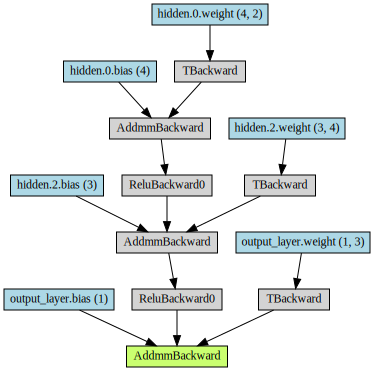

In [9]:
# visualize computational graph
x = torch.randn(1, num_features).to(device)
torchviz.make_dot(model(x), params=dict(model.named_parameters()))

### <img src="https://img.icons8.com/nolan/64/re-enter-pincode.png" style="height:50px;display:inline"> Weights Initialization
---
* As we have learned, neural networks are trained using a stochastic optimization algorithm, such as Gradient Descent, RMSprop, Adam and etc...
* Recall that these algorithms require initializing the parameters to some values. That is, they use randomness in order to find a good enough set of weights for the specific mapping function from inputs to outputs in your data that is being learned.
* These algroithms require that the weights of the network are initialized to small random values (random, but close to zero). 
    * Randomness is also used during the search process in the **shuffling of the training dataset** prior to each epoch, which in turn results in differences in the gradient estimate for each batch.
* Training deep models is a sufficiently difficult task that most algorithms are strongly affected by the choice of initialization (page 301, <a href="https://amzn.to/2H5wjfg">Deep Learning</a>, 2016).

#### Why Not Just Initialize With Zeros?
---
* We can use the same set of weights each time we train the network. For example, you could use the values of 0.0 for all weights.
* In this case, the equations of the learning algorithm would fail to make any changes to the network weights, and the model will be **stuck**. 
    * It is important to note that the bias weight in each neuron is set to zero by default, not a small random value.
* Specifically, neurons that are in the same hidden layer that is connected to the same inputs must have different weights for the learning algorithm to update the weights.
* **Symmetry Breaking**: initial parameters need to “break symmetry” between different units. If two hidden units with the same activation function are connected to the same inputs, then these units must have different initial parameters (page 301, <a href="https://amzn.to/2H5wjfg">Deep Learning</a>, 2016). 
    * Why? If they have the same initial parameters, then a deterministic learning algorithm applied to a deterministic cost and model will constantly update both of these units in the same way.
* Note that when you **constant the seed**, you will initialize with the same weight seach time. We do this when we want to get reproducible results (or in production).

### <img src="https://img.icons8.com/emoji/96/000000/on-arrow-emoji.png" style="height:50px;display:inline"> Types of Weight Initialization
---
* The initialization of the weights of neural networks is an active field of study as the careful initialization of the network can speed up the learning process.

* There is no single best way to initialize the weights of a neural network.

* We will review some of the popular initalization methods.

* **Unifrom** - initialize with values drawn from the uniform distribution $\mathcal{U}(a, b)$
    * In PyTorch - `torch.nn.init.uniform_(tensor, a=0.0, b=1.0)`
* **Normal** - initialize with values drawn from the normal distribution $\mathcal{N}(\text{mean}, \text{std}^2)$
    * In PyTorch - `torch.nn.init.normal_(tensor, mean=0.0, std=1.0)`
* **Constant** - initialize with the value $val$.
    * In PyTorch - `torch.nn.init.constant_(tensor, val)`
* **Ones** - Initialize with the scalar value 1.
    * In PyTorch - `torch.nn.init.ones_(tensor)`
* **Zeros** - Initialize with the scalar value 0.
    * In PyTorch - `torch.nn.init.zeros_(tensor)`

* **Xavier (Glorot) Uniform** - Initialize with values according to the method described in *Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)*, using a uniform distribution. The resulting tensor will have values sampled from $\mathcal{U}(-a, a)$ where $$ a = \text{gain} \times \sqrt{\frac{6}{\text{fan}_{in} + \text{fan}_{out}}} $$
    * `fan_in` is the number of input units in the weight tensor and `fan_out` is the number of output units in the weight tensor
    * In PyTorch - `torch.nn.init.xavier_uniform_(tensor, gain=1.0)`
    
* **Xavier (Glorot) Normal** - Initialize with values according to the method described in *Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)*, using a normal distribution. The resulting tensor will have values sampled from $\mathcal{N}(0,\text{std}^2)$ where $$ \text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan}_{in} + \text{fan}_{out}}} $$
    * `fan_in` is the number of input units in the weight tensor and `fan_out` is the number of output units in the weight tensor
    * In PyTorch - `torch.nn.init.xavier_normal_(tensor, gain=1.0)`

* **Kaiming (He) Uniform** - Initialize with values according to the method described in *Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)*, using a uniform distribution. The resulting tensor will have values sampled from $\mathcal{U}(-\text{bound}, \text{bound})$ where $$ \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan_mode}}} $$
    * In PyTorch - `torch.nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')`
    * `a` - the negative slope of the rectifier used after this layer (only used with `leaky_relu`)
    * `fan_mode` – either `fan_in` (default) or `fan_out`. Choosing `fan_in` preserves the magnitude of the variance of the weights in the forward pass. Choosing `fan_out` preserves the magnitudes in the backwards pass.
    * `nonlinearity` – the non-linear function (`nn.functional` name), recommended to use only with `relu` or `leaky_relu` (default).
    
* **Kaiming (He) Normal** - Initialize with values according to the method described in  *Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)*, using a normal distribution. The resulting tensor will have values sampled from $\mathcal{N}(0,\text{std}^2)$ where $$ \text{std} = \frac{\text{gain}}{\sqrt{\text{fan_mode}}} $$
    * In PyTorch - `torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')`

#### Interactive Demo
---
<a href="https://www.deeplearning.ai/ai-notes/initialization/">Different Initializations Demo</a>

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Neural Network Weight Initialization with PyTorch
---
* As from PyTorch 1.0, **most layers are initialized using Kaiming Uniform method by default**.
* Let's see how we change the initialization of a model.
* <a href="https://pytorch.org/docs/stable/nn.init.html">Official PyTorch initialization documentation</a>

In [7]:
# define hyper-parmeters and create our model
num_features = 2
output_dim = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 500
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# loss criterion
criterion = nn.MSELoss()
# model
model = HousePricesMLP(num_features, output_dim).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# use a different initialization for the model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
model.apply(weights_init)

HousePricesMLP(
  (hidden): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=3, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
)

In [11]:
boston_tensor_train_dataloader = DataLoader(boston_tensor_train_ds, batch_size=batch_size)

# training loop for the model
for epoch in range(num_epochs):
    epoch_losses = []
    for features, targets in boston_tensor_train_dataloader:
        # send data to device
        features = features.to(device)
        targets = targets.to(device)
        # forward pass
        output = model(features)
        # loss
        loss = criterion(output.view(-1), targets)
        # backward pass
        optimizer.zero_grad()  # clean the gradients from previous iteration
        loss.backward()  # autograd backward to calculate gradients
        optimizer.step()  # apply update to the weights
        epoch_losses.append(loss.item())
    if epoch % 50 == 0:
        print(f'epoch: {epoch} loss: {np.mean(epoch_losses)}')
        
# test error
model.eval()
with torch.no_grad():
    test_outputs = model(torch.from_numpy(x_test).float().to(device))
    test_error = criterion(test_outputs.view(-1), torch.from_numpy(y_test).float().to(device))
print(f'test MSE error: {test_error.item()}')

epoch: 0 loss: 624.5885009765625
epoch: 50 loss: 35.445608139038086
epoch: 100 loss: 28.66716480255127
epoch: 150 loss: 22.615984439849854
epoch: 200 loss: 20.051589488983154
epoch: 250 loss: 19.82143211364746
epoch: 300 loss: 19.730319499969482
epoch: 350 loss: 19.615483283996582
epoch: 400 loss: 19.475394248962402
epoch: 450 loss: 19.32789421081543
test MSE error: 15.348824501037598


## <img src="https://img.icons8.com/bubbles/50/000000/alps.png" style="height:50px;display:inline"> Deep Double Descent
---
* Double Descent in ML algorithms training: performance first improves, then gets worse, and then improves again with increasing model size, data size, or training time.
* This effect is often avoided through careful **regularization** or **early stopping**. 
    * While this behavior appears to be fairly universal, *we don’t yet fully understand why it happens*.

<img src="./assets/double_descent_1.png" style="height:300px">

* It can be seen that as we increase the number of parameters in a model, the test error initially decreases, increases, and, just as the model is able to fit the train set, undergoes a second descent. This different than what we saw when we talked about the bias-variance trade-off.
* Double descent also occurs over **train epochs**. 
    * Surprisingly, it can lead to a regime where **more data hurts**, and training a deep network on a larger train set actually performs worse.

#### Model-wise Double Descent
---
* There is a regime where **bigger models are worse**.
* The model-wise double descent phenomenon can lead to a regime where training on more data hurts.

<img src="./assets/double_descent_model.svg" style="height:300px">

In the figure, the peak in test error occurs around the interpolation threshold, **when the models are just barely large enough to fit the train set**.

#### Sample-wise Non-monotonicity
---
* There is a regime where **more samples hurts**.

<img src="./assets/double_descent_sample.svg" style="height:300px">

* In the figure, increasing the number of samples shifts the curve downwards towards lower test error. 
* However, since more samples require larger models to fit, increasing the number of samples also shifts the interpolation threshold (and peak in test error) to the right.
* For intermediate model sizes (red arrows), these two effects combine, and training on 4.5x more samples actually hurts test performance.

#### Epoch-wise Double Descent
---
* There is a regime where **training longer reverses overfitting**.

<img src="./assets/double_descent_epoch.png" style="height:300px">
<img src="./assets/double_descent_epoch_2.png" style="height:300px">

* The figures above show test and train error as a function of both model size and number of optimization steps.
* For a given number of optimization steps (fixed y-coordinate), test and train error exhibit model-size double descent.
* For a given model size (fixed x-coordinate), as training proceeds, **test and train error decreases, increases, and decreases again!**

**In general, the peak of test error appears systematically when models are just barely able to fit the train set.**

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Deep Learning - <a href="https://www.youtube.com/watch?v=kPXxbmBsFxs">Machine Learning Lecture 35 "Neural Networks / Deep Learning" -Cornell CS4780</a>
    * <a href="https://www.youtube.com/watch?v=zmu9wR2c7Z4">Machine Learning Lecture 36 "Neural Networks / Deep Learning Continued" -Cornell CS4780</a>
* Building a Network with PyTorch - <a href="https://www.youtube.com/watch?v=ixathu7U-LQ">Deep Learning and Neural Networks with Python and Pytorch</a>
* Weight Initialization - <a href="https://www.youtube.com/watch?v=m1gt7nxbB2k">UC Berkeley - STAT 157- Stabilize Training - Weight Initialization</a>
    * <a href="https://www.youtube.com/watch?v=tMjdQLylyGI">Krish Naik - Various Weight Initialization Techniques in Neural Network</a>
    * <a href="https://www.youtube.com/watch?v=s2coXdufOzE">Weight Initialization in a Deep Network (C2W1L11)</a>
* Deep Double Descent - <a href="https://www.youtube.com/watch?v=R29awq6jvUw">Henry AI Labs - Deep Double Descent</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/
* <a href="https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/">Jason Brownlee - Why Initialize a Neural Network with Random Weights?</a>
* <a href="https://openai.com/blog/deep-double-descent/">OpenAI - Deep Double Descent</a>